In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [32]:
x= torch.linspace(0,799,800)

In [33]:
y = torch.sin(x*2*3.1416/40)

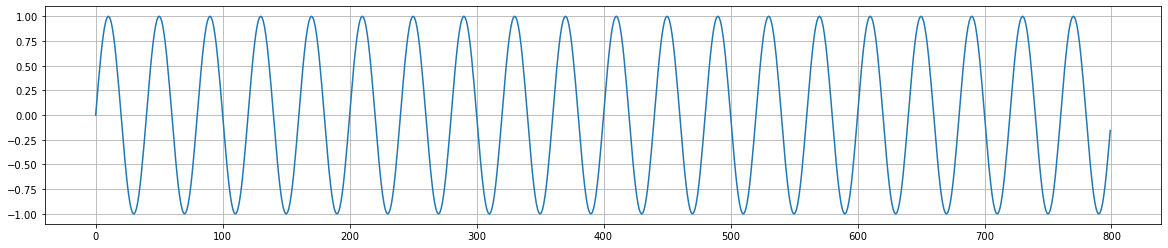

In [34]:
plt.figure(figsize=(20,4))
plt.plot(x, y)
plt.grid(True)
plt.show()

In [35]:
class SineDataSet(Dataset):
    def __init__(self, series, window_size, num_future_pt):
        self.series = series
        self.window_size = window_size
        self.num_future_pt = num_future_pt
        
    def __getitem__(self, idx):
        X = self.series[idx: idx + self.window_size]
        y = self.series[idx + self.window_size:idx+ self.window_size + self.num_future_pt]
        return X,y
    
    def __len__(self):
        return len(self.series) - self.window_size

In [36]:
train = y[:500]
test = y[500:]

## Seq2Seq (Multistep Output)

In [37]:
num_futures = 3
window_size= 40
train_ds = SeinDataSet(train, window_size, num_futures)
test_ds  = eSinDataSet(test, window_size, num_futures)

In [38]:
class EncoderRNN(nn.Module):
    
    def __init__(self, num_features, num_hidden):
        super().__init__()
        self.input_size = num_features
        self.hidden_size = num_hidden
        self.lstm = nn.LSTM(input_size= self.input_size, hidden_size=self.hidden_size)
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
    
    def initHidden(self):
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq):
        seq = seq.view(len(seq), 1, -1)
        out_lstm, hidden = self.lstm(seq, self.hidden)
        return out_lstm, hidden

In [39]:
class DecoderRNN(nn.Module):
    def __init__(self, num_hidden, num_output):
        super().__init__()
        self.hidden_size = num_hidden
        self.num_output = num_output
        self.input_size = 1
        self.lstm = nn.LSTM(input_size = self.input_size, hidden_size= self.hidden_size)
        self.linear = nn.Linear(in_features=self.hidden_size, out_features=num_output)
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
        
    def initHidden(self):
        self.hidden = (torch.zeros(1,1,self.hidden_size), torch.zeros(1,1,self.hidden_size))
        
    def forward(self, seq, hidden):
        seq = seq.view(1,1,-1)
        out_lstm, hidden = self.lstm(seq, self.hidden)
        out = self.linear(out_lstm.view(len(out_lstm), -1))
        return out, hidden
    

In [40]:
class Seq2Seq(nn.Module):
    def __init__(self, num_features, num_hidden, num_output, num_futures):
        super().__init__()
        self.num_features = num_features
        self.num_hidden = num_hidden
        self.num_output = num_output
        self.num_futures = num_futures

        self.encoder = EncoderRNN(self.num_features, self.num_hidden)
        self.decoder = DecoderRNN(self.num_hidden, self.num_output)
    
    def forward(self, seq, prev_y):
        encoder_out, encoder_hidden = self.encoder(seq)
        #placeholder for decoder output
        targets_ta = []
        #prev_output become the next input to the LSTM cell
        prev_out = prev_y
        prev_hidden = encoder_hidden
        
        for future_data in range(self.num_futures):
            decoder_out, decoder_hidden = self.decoder(prev_out, prev_hidden)
            prev_out = decoder_out
            prev_hidden = decoder_hidden
            targets_ta.append(prev_out.reshape(1))
        
        targets = torch.stack(targets_ta)
        return targets

In [41]:
model = Seq2Seq(1, 50, 1,num_futures)

In [42]:
model

Seq2Seq(
  (encoder): EncoderRNN(
    (lstm): LSTM(1, 50)
  )
  (decoder): DecoderRNN(
    (lstm): LSTM(1, 50)
    (linear): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [43]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss() 
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 5e-3, eta_min=1e-8, last_epoch=-1)

In [46]:
epochs = 100

for e in range(epochs):
    losses = []
    for i in range(len(train_ds)):
        train_features, train_label = train_ds[i]
        optimizer.zero_grad()
        seq_pred = model(train_features, train_features[window_size-1: window_size])
        loss = criterion(seq_pred, train_label)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    print(f"Epoch： {e} \t Loss: {torch.mean(torch.tensor(losses))}")

Epoch： 0 	 Loss: 0.07381021231412888
Epoch： 1 	 Loss: 0.07382520288228989
Epoch： 2 	 Loss: 0.07366549968719482
Epoch： 3 	 Loss: 0.07350040972232819
Epoch： 4 	 Loss: 0.07335011661052704
Epoch： 5 	 Loss: 0.07324381172657013
Epoch： 6 	 Loss: 0.07309720665216446
Epoch： 7 	 Loss: 0.07298165559768677
Epoch： 8 	 Loss: 0.0729009360074997
Epoch： 9 	 Loss: 0.0727882906794548
Epoch： 10 	 Loss: 0.07271862775087357
Epoch： 11 	 Loss: 0.07263205945491791
Epoch： 12 	 Loss: 0.07256443798542023
Epoch： 13 	 Loss: 0.07250112295150757
Epoch： 14 	 Loss: 0.07244863361120224
Epoch： 15 	 Loss: 0.07238145172595978
Epoch： 16 	 Loss: 0.07233547419309616
Epoch： 17 	 Loss: 0.0722736269235611
Epoch： 18 	 Loss: 0.07222533971071243
Epoch： 19 	 Loss: 0.07218145579099655
Epoch： 20 	 Loss: 0.07213857024908066
Epoch： 21 	 Loss: 0.0720941424369812
Epoch： 22 	 Loss: 0.07204911857843399
Epoch： 23 	 Loss: 0.07202072441577911
Epoch： 24 	 Loss: 0.0719771757721901
Epoch： 25 	 Loss: 0.07194218039512634
Epoch： 26 	 Loss: 0.0719126

In [47]:
model = model.eval()

with torch.no_grad():
    losses = []
    for i in range(len(test_ds)):
        feature, label = test_ds[i]
        pred = model(feature, feature[-1].unsqueeze(dim=0))
        loss = criterion(pred, label)
        losses.append(loss)
    print(torch.mean(torch.tensor(losses)))

tensor(0.0568)


In [48]:
labels = []
predictions = []

for i in range(len(test_ds)):
    feature, label = test_ds[i]
    pred = model(feature, feature[-1].unsqueeze(dim=0))
    labels.append(label)
    predictions.append(pred)

In [49]:
labels = torch.cat(labels)
predictions = torch.cat(predictions)

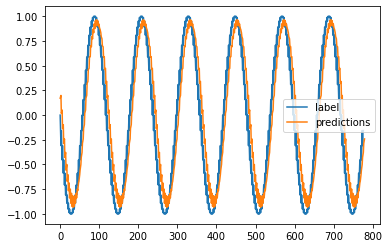

In [50]:
plt.plot(labels, label="label")
plt.plot(predictions.flatten().detach().numpy(), label='predictions')
plt.legend()
plt.show()